Author documentation: 
- Student data, timesheets
- Required libraries and installs (e.g. „pip“ commands)
- Description of data and ground truth + split for training, testing, validation. Please do not include the videos themselves.
- Description of feature extraction methods (if applicable)
- Classification: Process and results of training and testing
- Results: Results of validation, indicators + the mandatory ROC curves of classifier performance
- Discussion of results

# Similarity Modeling 1/2: Recognizing Swedish Chef with Deep Learning  

#### Student
Matthias Hofmaier (11944050)
#### Timesheet
2022/10/10 - 2022/10/10    | Watch lecture videos and write abstracts

2022/11/23 | 16:30 - 18:00 | Setup Jupyter environment and project          

2022/11/23 | 18:00 - 19:30 | Exploration and preparation of ground truth

2022/11/23 | 19:30 - 20:30 | Research for potential implementation strategies

2022/11/24 | 09:00 - 11:30 | Video to audio conversion and spectrogram creation

2022/11/26 | 14:00 - 16:00 | Implemented CNN training pipeline

2022/11/27 | 10:00 - 11:00 | Team meeting

2022/12/03 | 13:00 - 16:30 | Setup COLAB and implement CNN training pipeline

2022/12/04 | 14:00 - 18:00 | Experiment with different CNN architectures

2022/12/04 | 19:00 - 20:00 | Team meeting

## Google colab integration

In [2]:
# This code block enables this notebook to run on google colab.
try:
    from google.colab import drive
    print('Running in colab...\n===================')
    COLAB = True
    drive.mount('/content/gdrive')
    root_path = 'gdrive/MyDrive/similarity-modeling'
    #!pip install -r gdrive/MyDrive/project-transformers-t10/requirements.txt --use-deprecated=legacy-resolver
    #print('Installed dependencies!\n=======================')

except:
    print('=======================\nNOT running in colab...\n=======================')
    COLAB = False

Running in colab...
Mounted at /content/gdrive


## Required libraries and installs
**We use Python 3.9**

In [3]:
if COLAB:
    !cat $root_path/notebooks/requirements-dl-audio.txt
    !pip install -r $root_path/notebooks/requirements-dl-audio.txt
else:
    !cat requirements-dl-audio.txt
    #!pip install -r requirements-dl-audio.txt

pandas
numpy
matplotlib
opencv-python
librosa==0.9.2
tqdm
tensorflow==2.9.2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 214 kB 14.6 MB/s 
  Attempting uninstall: librosa
    Found existing installation: librosa 0.8.1
    Uninstalling librosa-0.8.1:
      Successfully uninstalled librosa-0.8.1


**NOTE:** ffmpeg has to be installed on your device!
This can be done with one of the following commands:

In [3]:
#!brew install ffmpeg # MacOS (tested)
#!sudo apt install ffmpeg # Ubuntu (not tested)

For windows check: https://phoenixnap.com/kb/ffmpeg-windows

## Imports

In [4]:
import os

import cv2
import librosa
import librosa.display
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras import datasets, layers, models


## Constants

In [5]:
if COLAB:
    DATA_PATH = os.path.join(root_path, "data")
else:
    DATA_PATH = "../data/"

GROUND_TRUTH_PATH = os.path.join(DATA_PATH, "sim12-ground-truth-muppets")
VIDEO_PATH = os.path.join(DATA_PATH, "video")
PROCESSED_DATA_PATH = os.path.join(DATA_PATH, "processed")


RANDOM_STATE = 42

# 1. Data Preparation

## 1.1 Load ground truth data
The columns in the CSV files indicate at which frames Kermit, Waldorf & Statler, Pigs and/or the Danish chef are visually present (no prefix) or can be heared ("Audio_*").

In [6]:
gts = []
for fname in os.listdir(GROUND_TRUTH_PATH):
    if fname.startswith("GroundTruth"):
        df = pd.read_csv(os.path.join(GROUND_TRUTH_PATH, fname), sep=";")
        gts.append(df)
gts[0].head()

,Video,Frame_number,Kermit,Pigs,Audio_Pigs,Cook,Audio_Cook,StatlerWaldorf,Audio_StatlerWaldorf,Audio_MissPiggy
0,343,0,0,0,0,0,0,0,0,0
1,343,1,0,0,0,0,0,0,0,0
2,343,2,0,0,0,0,0,0,0,0
3,343,3,0,0,0,0,0,0,0,0
4,343,4,0,0,0,0,0,0,0,0


The column that is of our interest is 'Audio_Cook'.

## 1.2 Load video data

In [7]:
# def load_video(path):
videos = []
for fname in os.listdir(VIDEO_PATH):
    if fname.startswith("Muppets"):
        vidcap = cv2.VideoCapture(os.path.join(VIDEO_PATH, fname))
        fps = vidcap.get(cv2.CAP_PROP_FPS)
        videos.append(vidcap)
        print(f"Loaded video {fname} with {fps} frames per second")

Loaded video Muppets-02-01-01.avi with 25.0 frames per second
Loaded video Muppets-02-04-04.avi with 25.0 frames per second
Loaded video Muppets-03-04-03.avi with 25.0 frames per second


All of the videos have 25 frames per second. This comes in handy for the exploration of csv data.

In [8]:
FPS = 25

## 1.3 Show some descriptions of the data

Video: 343
Number of frames: 38498
Number of frames with Audio_Cook: 284
Length: 1539.92 seconds


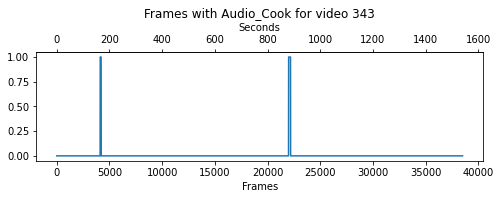

Video: 211
Number of frames: 38681
Number of frames with Audio_Cook: 1157
Length: 1547.24 seconds


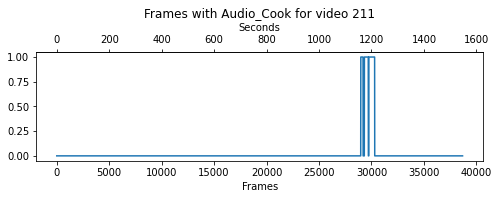

Video: 244
Number of frames: 38706
Number of frames with Audio_Cook: 0
Length: 1548.24 seconds


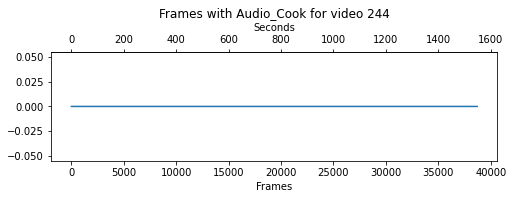

In [9]:
def show_gt_description(df, column="Audio_Cook", fps=25):
    print(f"Video: {df.loc[0, 'Video']}")
    print(f"Number of frames: {df['Frame_number'].count()}")
    print(
        f"Number of frames with {column}: {df.loc[df[column] == 1, 'Frame_number'].count()}"
    )
    print(f"Length: {len(df['Frame_number']) / fps} seconds")

    # plotting with frames and seconds as x-axis
    fig = plt.figure(figsize=(8, 2))
    ax1 = fig.add_subplot(111)
    ax1.set_title(f"Frames with {column} for video {df.loc[0, 'Video']}")
    ax1.set_xlabel("Frames")
    frame_indicator = np.zeros(len(df["Frame_number"]))
    frame_indicator[df[df[column] == 1].index] = 1
    ax1.plot(df[column].index, frame_indicator)

    def frames_to_sec(x):
        return x / fps

    def sec_to_frames(x):
        return x * fps

    ax2 = ax1.secondary_xaxis("top", functions=(frames_to_sec, sec_to_frames))
    ax2.set_xlabel("Seconds")
    plt.show()


show_gt_description(gts[0])
show_gt_description(gts[1])
show_gt_description(gts[2])

We can see that the swedish chef occurs only in the audio of video 343 and 211. In the next step, we will combine our ground truth dataframes into one, filter for the Audio_Cook column and add a column seconds to the data frame. 

## 1.4 Combine data frames, filter for Audio_Cook and add seconds

In [18]:
df_gt = pd.concat(gts)
df_gt["Seconds"] = df_gt["Frame_number"] / FPS
df_gt = df_gt[["Video", "Frame_number", "Seconds", "Audio_Cook"]]
df_gt.head()

,Video,Frame_number,Seconds,Audio_Cook
0,343,0,0.00,0
1,343,1,0.04,0
2,343,2,0.08,0
3,343,3,0.12,0
4,343,4,0.16,0


In the next step, we will convert the video files to wav format

## 1.5 Convert videos to wav

In [11]:
map_code_to_file = {211: "02-01-01", 244: "02-04-04", 343: "03-04-03"}

AUDIO_PATH = "../data/audio/"
os.makedirs(AUDIO_PATH, exist_ok=True)

for code in df_gt["Video"].unique():
    fname_in = f"Muppets-{map_code_to_file[code]}.avi"
    fname_out = f"Muppets-{map_code_to_file[code]}.wav"
    command2wav = f"ffmpeg -i {os.path.join(VIDEO_PATH, fname_in)} {os.path.join(AUDIO_PATH, fname_out)}"
    os.system(command2wav)

    df_gt.loc[
        df_gt["Video"] == code, "fname_audio"
    ] = fname_out  # save audio filename to data frame

    print(f"Converted {fname_in} to {fname_out}")

Converted Muppets-03-04-03.avi to Muppets-03-04-03.wav
Converted Muppets-02-01-01.avi to Muppets-02-01-01.wav
Converted Muppets-02-04-04.avi to Muppets-02-04-04.wav


## 1.6 Create Mel Spectrograms
We will now use the converted audio data to create Mel Spectrograms. The difficulty is that we have annotations on a frame level and we will later on test our models against this ground truth. Quite often, CNN-based audio classification models work with spectrogram snippets capturing around 1 second of the audio file. For our task, this would probably be not sufficient, as we need to predict on a much higher resolution (1 frame = 40ms). One approach is to use only a few samples and a even smaller hop length when calculating the spectrograms. Another approach would be to create lower resolution spectrograms, classify them and then use post-processing to approximate the frame-level annotations. In the beginning, we will focus on the first mentioned approach: 

With a sample rate of 16kHz, 1 frame (40 ms) equals to 640 audio samples.
We will use 320 samples as FFT window and a hop length of 160 samples. This transforms each frame (of 40 ms audio) to 4 spectrogram frames. We are using 4 spectrogram frames so that the CNN can at least use a little bit of temporal information (and not only 1 single spectrogram frame at a time). We will use 64 mel frequency bands as this showed good results in previous implementations.

S.shape =(64, 153946)


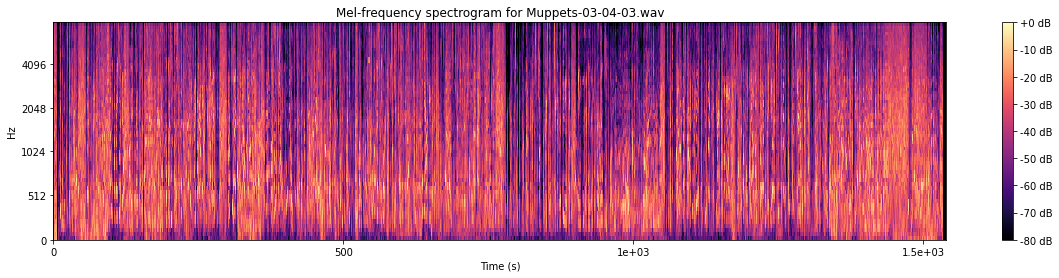

S.shape =(64, 154685)


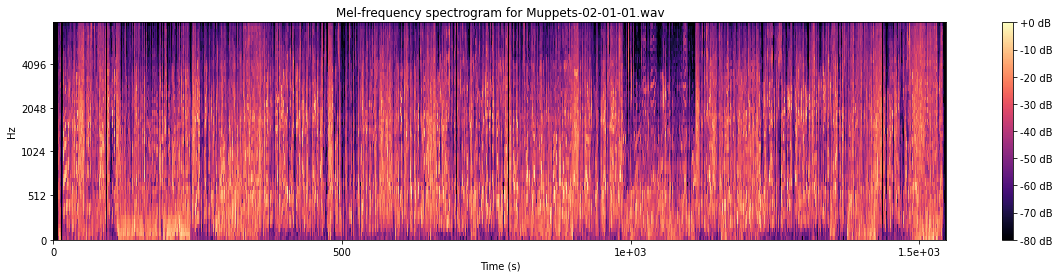

S.shape =(64, 154781)


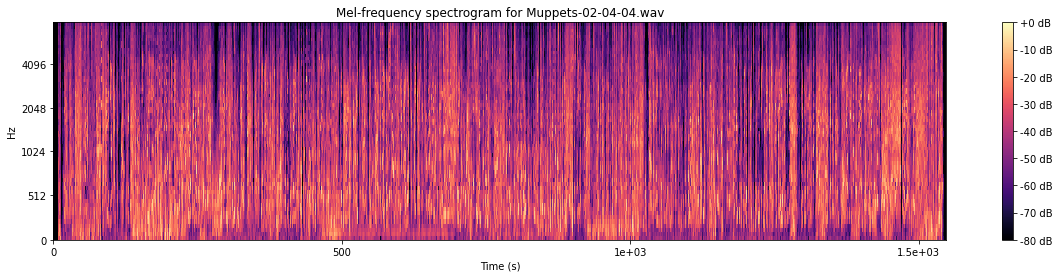

In [12]:
SR = 16000  # we will use a sample rate of 16kHz
N_FFT = 320  # = 20ms @ 16kHz
HOP_LENGTH = 160  # = 10ms @ 16kHz
N_MELS = 64

spectrograms = {}

for fname_audio in df_gt["fname_audio"].unique():
    y, sr = librosa.load(os.path.join(AUDIO_PATH, fname_audio), sr=SR)
    S = librosa.feature.melspectrogram(
        y=y, sr=sr, n_fft=N_FFT, hop_length=HOP_LENGTH, n_mels=N_MELS
    )
    print(f"{S.shape =}")
    spectrograms[fname_audio] = S

    fig, ax = plt.subplots(figsize=(20, 4))
    S_dB = librosa.power_to_db(S, ref=np.max)
    img = librosa.display.specshow(
        S_dB,
        x_axis="s",
        y_axis="mel",
        sr=sr,
        n_fft=N_FFT,
        hop_length=HOP_LENGTH,
        ax=ax,
    )
    fig.colorbar(img, ax=ax, format="%+2.0f dB")
    ax.set(title=f"Mel-frequency spectrogram for {fname_audio}")
    plt.show()

## 1.7 Create train, validation, test split
We will use 70% of the frames for training, 15% for validation and 15% for testing. We split in a stratified manner, to retain an equal distribution of the label across all data splits. 

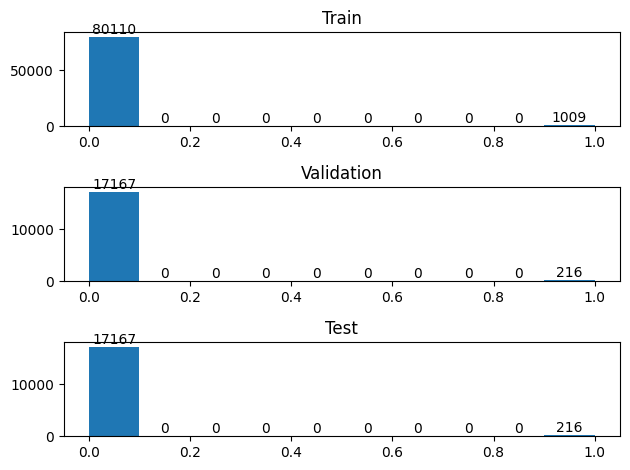

In [52]:
train, _val_test = train_test_split(
    df_gt, test_size=0.3, stratify=df_gt["Audio_Cook"], random_state=RANDOM_STATE
)

val, test = train_test_split(
    _val_test, test_size=0.5, stratify=_val_test["Audio_Cook"], random_state=RANDOM_STATE
)

fig, axs = plt.subplots(3)
_, _, bars_train = axs[0].hist(train["Audio_Cook"])
axs[0].bar_label(bars_train)
axs[0].set_title("Train")
_, _, bars_val = axs[1].hist(val["Audio_Cook"])
axs[1].bar_label(bars_val)
axs[1].set_title("Validation")
_, _, bars_test = axs[2].hist(test["Audio_Cook"])
axs[2].bar_label(bars_test)
axs[2].set_title("Test")
plt.tight_layout()
plt.show()

## 1.8 Create class weights
As our task boils down to an imbalanced classification problem, we will employ class weights. The class weights are calculated as the inverse class proportions in the training set.

In [41]:
cw_negative = len(train) / len(train[train["Audio_Cook"] == 0]) 
cw_positive = len(train) / len(train[train["Audio_Cook"] == 1])

print(f"Class weight Cook not present: {cw_negative}")
print(f"Class weight Cook present: {cw_positive}")

class_weights = {
    0: cw_negative,
    1: cw_positive
}

Class weight Cook not present: 1.0125951816252652
Class weight Cook present: 80.39544103072349


## 1.9 Create X, y arrays from spectrograms 
We will create X and y arrays, where X contains a 64x4 spectrogram snippet for each video frame and y the corresponding label.

In [46]:
def create_Xy_from_spectrograms(df, spectrograms, stv_rate=4): # stv_rate = spectrogram to video frame rate ratio
    X = []
    y = []
    frame_unsuccesful = [] # in this array we will story frame + video for which we did not find spectrogram info
    for idx, row in tqdm(df.iterrows(), total=len(df)):
        spec_slice_horizontal = slice(row["Frame_number"] * stv_rate, (row["Frame_number"] +1) * stv_rate)
        spec = spectrograms[row["fname_audio"]]
        snippet = spec[:, spec_slice_horizontal]
        if snippet.shape[1] < 4:
            frame_unsuccesful.append(str(row['Video']) + '_' + str(row['Frame_number']))
        else:
            X.append(snippet)
            y.append(row["Audio_Cook"])
    X = np.dstack(X)
    X = np.swapaxes(X, 0, 2)
    X = np.swapaxes(X, 1, 2)
    X = np.expand_dims(X, axis=3)
    y = np.array(y)
    
    print(f"Created X array with shape {X.shape}")
    print(f"Created y array with shape {y.shape}")
    print(f"For {len(frame_unsuccesful)} video frames, we did not find a spectrogram frame")
    
    return X, y, frame_unsuccesful

X_train, y_train, fu_train = create_Xy_from_spectrograms(train, spectrograms)
X_val, y_val, fu_val = create_Xy_from_spectrograms(val, spectrograms)
X_test, y_test, fu_test = create_Xy_from_spectrograms(test, spectrograms)


# Save snippets + labels to file
os.makedirs(PROCESSED_DATA_PATH, exist_ok=True)
with open(os.path.join(PROCESSED_DATA_PATH, "X_train_audio_cook.npy"), 'wb') as f:
          np.save(f, X_train, allow_pickle=False)
with open(os.path.join(PROCESSED_DATA_PATH, "y_train_audio_cook.npy"), 'wb') as f:
          np.save(f, y_train, allow_pickle=False)
with open(os.path.join(PROCESSED_DATA_PATH, "X_val_audio_cook.npy"), 'wb') as f:
          np.save(f, X_val, allow_pickle=False)
with open(os.path.join(PROCESSED_DATA_PATH, "y_val_audio_cook.npy"), 'wb') as f:
          np.save(f, y_val, allow_pickle=False)
with open(os.path.join(PROCESSED_DATA_PATH, "X_test_audio_cook.npy"), 'wb') as f:
          np.save(f, X_test, allow_pickle=False)
with open(os.path.join(PROCESSED_DATA_PATH, "y_test_audio_cook.npy"), 'wb') as f:
          np.save(f, y_test, allow_pickle=False)

100%|██████████| 81119/81119 [00:03<00:00, 21084.48it/s]


Created X array with shape (81095, 64, 4, 1)
Created y array with shape (81095,)
For 24 video frames, we did not find a spectrogram frame


100%|██████████| 17383/17383 [00:00<00:00, 20810.61it/s]


Created X array with shape (17377, 64, 4, 1)
Created y array with shape (17377,)
For 6 video frames, we did not find a spectrogram frame


100%|██████████| 17383/17383 [00:00<00:00, 20533.37it/s]


Created X array with shape (17380, 64, 4, 1)
Created y array with shape (17380,)
For 3 video frames, we did not find a spectrogram frame


For some of the video frames, we do not have spectrogram frames. This should be further investigated, but as it is only a very small number compared to the total number of frames, we will ignore this for now.

## 1.10 Load spectrogram snippets

In [10]:
if os.path.exists(PROCESSED_DATA_PATH): 
    with open(os.path.join(PROCESSED_DATA_PATH, "X_train_audio_cook.npy"), 'rb') as f:
          X_train = np.load(f)
    with open(os.path.join(PROCESSED_DATA_PATH, "y_train_audio_cook.npy"), 'rb') as f:
          y_train = np.load(f)
    with open(os.path.join(PROCESSED_DATA_PATH, "X_val_audio_cook.npy"), 'rb') as f:
          X_val = np.load(f)
    with open(os.path.join(PROCESSED_DATA_PATH, "y_val_audio_cook.npy"), 'rb') as f:
          y_val = np.load(f)
    with open(os.path.join(PROCESSED_DATA_PATH, "X_test_audio_cook.npy"), 'rb') as f:
          X_test = np.load(f)
    with open(os.path.join(PROCESSED_DATA_PATH, "y_test_audio_cook.npy"), 'rb') as f:
          y_test = np.load(f)
    print("Loaded spectrogram snippets from disk!")

Loaded spectrogram snippets from disk!


# 2. Modeling

## 2.1 Standardize features
We will standardize the input features by subtracting the mean and dividing by the standard deviation of X_train. With that we end up with features having mean=0 and std=1.

In [11]:
xt_mean = X_train.mean()
xt_std = X_train.std()
print(f"Mean of X_train: {xt_mean}")
print(f"Std of X_train: {xt_std}")

X_train = (X_train - xt_mean) / xt_std
X_val = (X_val - xt_mean) / xt_std
X_test = (X_test - xt_mean) / xt_std

Mean of X_train: 0.00807117484509945
Std of X_train: 0.0433158241212368


## 2.1 Create datasets

In [12]:
dataset_train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
dataset_val = tf.data.Dataset.from_tensor_slices((X_val, y_val))
dataset_test = tf.data.Dataset.from_tensor_slices((X_test, y_test))


BATCH_SIZE = 128
dataset_train = dataset_train.shuffle(buffer_size=1024).batch(BATCH_SIZE)
dataset_val = dataset_val.batch(BATCH_SIZE)
dataset_test = dataset_test.batch(BATCH_SIZE)

## 2.2 Define CNN model

In [81]:
input_shape = X_train.shape[1:]
model = models.Sequential()
model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=input_shape))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
#model.add(layers.Conv2D(64, (3, 3), activation='relu'))
#model.add(layers.BatchNormalization())
#model.add(layers.MaxPooling2D((2, 1)))
#model.add(layers.Conv2D(128, (3, 3), activation='relu'))
#model.add(layers.BatchNormalization())
#model.add(layers.Conv2D(64, (2, 2), activation='relu'))
#model.add(layers.BatchNormalization())

model.add(layers.Flatten())
#model.add(layers.Dense(500, activation='relu'))
model.add(layers.Dense(250, activation='relu',  kernel_regularizer='l2'))
model.add(layers.BatchNormalization())
#model.add(layers.Dense(125, activation='relu'))
model.add(layers.Dropout(rate=0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_65 (Conv2D)          (None, 62, 2, 64)         640       
                                                                 
 batch_normalization_30 (Bat  (None, 62, 2, 64)        256       
 chNormalization)                                                
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 31, 1, 64)        0         
 g2D)                                                            
                                                                 
 flatten_17 (Flatten)        (None, 1984)              0         
                                                                 
 dense_44 (Dense)            (None, 250)               496250    
                                                                 
 batch_normalization_31 (Bat  (None, 250)            

## 2.2 Compile and train CNN model

In [78]:
N_EPOCHS = 200

es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.AUC(name='prc', curve='PR', num_thresholds=200), tf.keras.metrics.Recall(name="recall"), tf.keras.metrics.Precision(name="precision")]
              )

history = model.fit(dataset_train, epochs=N_EPOCHS, class_weight=class_weights, 
                    validation_data=dataset_val, 
                    callbacks=[es_callback]
                    )

Epoch 1/200
634/634 [==============================] - 7s 9ms/step - loss: 2.7260 - prc: 0.0426 - recall: 0.6700 - precision: 0.0228 - val_loss: 1.2493 - val_prc: 0.0581 - val_recall: 0.6065 - val_precision: 0.0344
Epoch 2/200
634/634 [==============================] - 5s 8ms/step - loss: 1.7069 - prc: 0.0635 - recall: 0.6829 - precision: 0.0294 - val_loss: 0.9893 - val_prc: 0.0809 - val_recall: 0.8102 - val_precision: 0.0290
Epoch 3/200
634/634 [==============================] - 6s 9ms/step - loss: 1.5531 - prc: 0.0671 - recall: 0.7007 - precision: 0.0327 - val_loss: 1.0642 - val_prc: 0.0556 - val_recall: 0.8287 - val_precision: 0.0208
Epoch 4/200
634/634 [==============================] - 5s 7ms/step - loss: 1.4495 - prc: 0.0783 - recall: 0.7175 - precision: 0.0347 - val_loss: 0.9478 - val_prc: 0.0688 - val_recall: 0.7546 - val_precision: 0.0309
Epoch 5/200
634/634 [==============================] - 5s 8ms/step - loss: 1.3977 - prc: 0.0983 - recall: 0.7294 - precision: 0.0371 - val_l

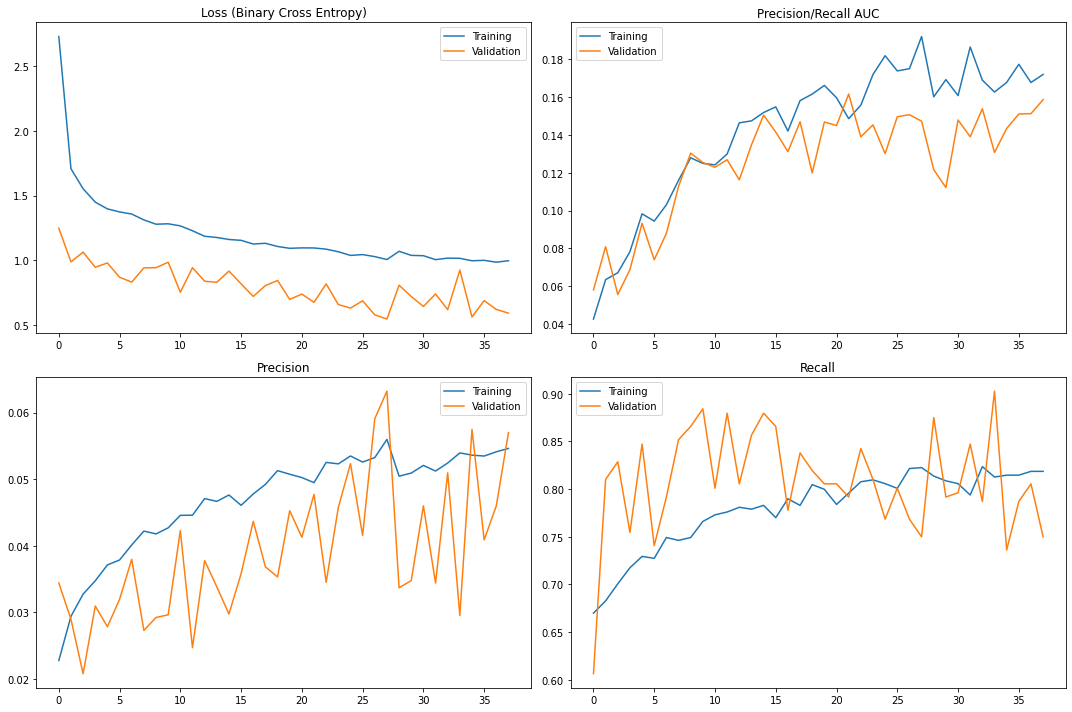

In [79]:
def plot_training_history(history):
    history = history.history
    epochs = np.arange(len(history["loss"]))
    
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))
    axs[0, 0].plot(epochs, history["loss"], label="Training")
    axs[0, 0].plot(epochs, history["val_loss"], label="Validation")
    axs[0, 0].set_title("Loss (Binary Cross Entropy)")
    axs[0, 0].legend()
    axs[0, 1].plot(epochs, history["prc"], label="Training")
    axs[0, 1].plot(epochs, history["val_prc"], label="Validation")
    axs[0, 1].set_title("Precision/Recall AUC")
    axs[0, 1].legend()

    axs[1, 0].plot(epochs, history["precision"], label="Training")
    axs[1, 0].plot(epochs, history["val_precision"], label="Validation")
    axs[1, 0].set_title("Precision")
    axs[1, 0].legend()

    axs[1, 1].plot(epochs, history["recall"], label="Training")
    axs[1, 1].plot(epochs, history["val_recall"], label="Validation")
    axs[1, 1].set_title("Recall")
    axs[1, 1].legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)
#history.history

After experimenting with different CNN architectures, we conclude that our frame level spectrogram approach does not produce satisfactory results and that we have to come up with another strategy which uses bigger spectrogram snippets for model training and prediction.